<a href="https://colab.research.google.com/github/prog815/progOrder/blob/main/%D0%BE%D1%82%D0%B1%D0%BE%D1%80_%D0%B2_%D0%B0%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [1]:
! pip install finam-export
! pip install git+https://github.com/prog815/progGA
! pip install git+https://github.com/prog815/progOrder

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-bodublux
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-bodublux
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3732 sha256=6123d69b8e2912945efa9c94517ca44a69cd15c2660869810675109f6260ef81
  Stored in directory: /tmp/pip-ephem-wheel-cache-e7xmg_k_/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA
  Cloning https://github.com/prog815/progOrder to /tmp/pip-req-build-ra9sltso
  Running command git clone -q https://github.com/prog815/progOrder /tmp/pip-req-build-ra9sltso
  Created wheel for progOrder: filename=progOrder-0.0.3-cp36-none-any.whl size=2381 sha256=ae8394831623297b929b025eeb7366b9c961f9ad0c0ce775b53097e567e83278
  Stored in directory: /tmp/pip-ephem-wheel-cache-hxsgixlc/wheels/55/73/64/80cff258e67e5c7a4b92084f656d1e4f2f48a7543da44468f2
Successfully built progOrder


In [2]:
from finam import Exporter, Market
import datetime
import pandas as pd
import numpy as np
import seaborn as snb
import matplotlib.pyplot as plt
from progGA import ListGenetic
from progOrder import getBuySellForData
import pickle
import os
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import tensorflow as tf
# import tensorflow.keras as keras
# import tensorflow.keras.layers as layers

from sklearn.metrics import confusion_matrix,f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

import bz2

In [11]:
np.set_printoptions(precision=5)

# Загрузка данных

In [3]:
exporter = Exporter()
sber = exporter.lookup(code='SBER', market=Market.SHARES)
data = exporter.download(sber.index[0],market=Market.SHARES,start_date=datetime.date(2008, 1, 1))
data.drop('<TIME>',axis=1,inplace=True)
data.set_index('<DATE>',inplace=True)
data.set_index(pd.to_datetime(data.index,format='%Y%m%d'),inplace=True)
data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
<DATE>,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562
2008-01-10,102.07,103.81,101.53,103.53,39745084
2008-01-11,103.60,105.45,102.86,104.70,32814608
2008-01-14,104.28,105.30,104.20,105.00,20709850
2008-01-15,105.20,106.60,104.80,105.71,51441473
...,...,...,...,...,...
2020-12-28,270.89,275.19,269.73,274.70,38838530
2020-12-29,275.91,276.43,271.26,272.00,38984890
2020-12-30,272.50,274.24,270.12,271.65,31509500


In [4]:
ohlcv = data.values[:,:5]
d_ohlcv = np.array(ohlcv)
for n in range(1,len(ohlcv)):
    b = ohlcv[n-1,3]
    d_ohlcv[n,:] = (ohlcv[n,:] - b) / b
d_ohlcv[0,:] = np.nan

data['dOpen'] = d_ohlcv[:,0]
data['dHigh'] = d_ohlcv[:,1]
data['dLow'] = d_ohlcv[:,2]
data['dClose'] = d_ohlcv[:,3]

data

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,dOpen,dHigh,dLow,dClose
<DATE>,,,,,,,,,
2008-01-09,101.99,103.70,100.72,101.85,32124562,NaN,NaN,NaN,NaN
2008-01-10,102.07,103.81,101.53,103.53,39745084,0.002160,0.019244,-0.003142,0.016495
2008-01-11,103.60,105.45,102.86,104.70,32814608,0.000676,0.018545,-0.006472,0.011301
2008-01-14,104.28,105.30,104.20,105.00,20709850,-0.004011,0.005731,-0.004776,0.002865
2008-01-15,105.20,106.60,104.80,105.71,51441473,0.001905,0.015238,-0.001905,0.006762
...,...,...,...,...,...,...,...,...,...
2020-12-28,270.89,275.19,269.73,274.70,38838530,0.000924,0.016812,-0.003362,0.015001
2020-12-29,275.91,276.43,271.26,272.00,38984890,0.004405,0.006298,-0.012523,-0.009829
2020-12-30,272.50,274.24,270.12,271.65,31509500,0.001838,0.008235,-0.006912,-0.001287


# Поиск гиперпараметров

## Целевая функция

In [12]:
# %%time

valLen = 0.2        # глубина/доля валидации для генетики
orderLifeLen = 50   # срок жизни ордера

# --------------------------------------------------

def y2bs(y):
    s = y % 2
    b = ( y - s ) // 2
    return (b,s)

# --------------------------------------------------

bs2y = lambda b,s: b*2+s

# --------------------------------------------------

num2bs = lambda num : np.array([[b,s] for b,s in zip(*y2bs(num))])

# --------------------------------------------------

def kach(PR,TR,dTP,dSL):
    return np.mean(PR*(TR*dTP-(1-TR)*dSL))

# --------------------------------------------------

class Element:
    
    lookback = None
    model = None
    dTP = None
    dSL = None
    
    def __init__(self,model,lookback,dTP,dSL):
        self.lookback = lookback
        self.model = model
        self.dTP = dTP
        self.dSL = dSL

    def predict(self):
        X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(self.lookback)])
        idx = ~np.any(np.isnan(X),axis=1)
        y_ = X[:,0] * np.nan
        b_, s_ = np.copy(y_), np.copy(y_)
        y_[idx] = self.model.predict(X[idx])
        b_[idx],s_[idx] = y2bs(y_[idx])
        return b_,s_
        
# --------------------------------------------------

class Ansambl:
    elements = None
    count = None
    last = None

    def __init__(self,cnt):
        self.count = cnt
        self.elements = [ None ] * self.count
        self.last = -1

    def append(self,model,lookback,dTP,dSL):
        element = Element(model=model,lookback=lookback,dTP=dTP,dSL=dSL)
        self.last += 1
        self.elements[self.last % self.count] = element

    def predict(self):
        b,s,dTP,dSL = [],[],[],[]
        for element in self.elements:
            try:
                b_,s_ = element.predict()
                dTP_, dSL_ = element.dTP, element.dSL
                b.append(b_)
                s.append(s_)
                dTP.append(dTP_)
                dSL.append(dSL_)
            except Exception:
                pass
        b_ = np.mean(b,axis=0)
        s_ = np.mean(s,axis=0)
        dTP_,dTP_std = np.mean(dTP),np.std(dTP)
        dSL_,dSL_std = np.mean(dSL),np.std(dSL)

        b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL_,dTP=dTP_)
        bs_y = np.vstack((b,s)).T
        bs_y_ = np.vstack((b_,s_)).T
        idx = ~np.any(np.isnan(bs_y + bs_y_),axis=1)
        res = kach(np.round(bs_y_[idx]),bs_y[idx],dTP_,dSL_)

        return b_,s_,dTP_,dSL_,dTP_std,dSL_std,res


ansmbl = Ansambl(cnt=100)

# --------------------------------------------------

def getQualityMethod(lookback,     # окно задержки
                     max_depth,    # максимальная глубина дерева
                     n_estimators, # кол-во эстиматоров
                     dTP,          # тейк-профит
                     dSL):         # стоплос
                     
    # подготовка сигналов
    b,s = getBuySellForData(ohlcv[:,:-1],orderLifeLen=orderLifeLen,dSL=dSL,dTP=dTP)

    # подготовка входов
    X = np.hstack([data[['dOpen','dHigh','dLow','dClose','<VOL>']].shift(n) for n in range(lookback)])
    # y = np.vstack([b,s]).T
    y = b*2+s

    # отбор реальных значений
    idx = ~np.any(np.isnan(X),axis=1)
    X = X[idx]
    y = y[idx]

    # разделение выборок
    try:
        X_learn, X_valid, y_learn, y_valid = train_test_split(X,y,shuffle=True,test_size=valLen,stratify=y)
    except Exception:
        return -dSL
    
    # создание модели

    model = RandomForestClassifier(max_depth=max_depth,class_weight='balanced',n_estimators=n_estimators)

    # обучение модели

    model.fit(X_learn, y_learn)

    # возвращаем точности на отборе генетики
    
    # print(model.evaluate(X_valid,y_valid))
    pred_valid = model.predict(X_valid)
    # print(np.mean(pred_valid,axis=0),np.std(pred_valid,axis=0))
    # print('pred_valid',np.unique(pred_valid,return_counts=True))
    # print('y_valid',np.unique(y_valid,return_counts=True))

    # print(confusion_matrix(y_valid,pred_valid))
    # print(classification_report(y_valid,pred_valid))
    
    # raise Exception(1)

    res = kach(num2bs(pred_valid),num2bs(y_valid),dTP,dSL)

    if res == 0.0:  # не нужны тупые бездействующие модели
        res = -dSL*2.0

    # element = Element(model=model,lookback=lookback,dTP=dTP,dSL=dSL)
    if res > 0:
        ansmbl.append(model=model,lookback=lookback,dTP=dTP,dSL=dSL)

    return res

res = getQualityMethod(30,7,200,0.004,0.01)
print(res)

-0.0015433436532507742


## Создание модели

### Создание

In [13]:
modelGA = ListGenetic(pop_size = 200,
                      lookback = range(10,300),
                      max_depth = range(2,100),
                      n_estimators = range(10,500),
                      dTP = np.round(np.arange(0.0001,0.01,0.0001),4),
                      dSL = np.round(np.arange(0.0001,0.01,0.0001),4),
                      quality_method=getQualityMethod)

### или загрузка с диска

In [14]:
fn = '/content/drive/My Drive/prog/model_oa_04.01.2021.pkl'
fn_ans = '/content/drive/My Drive/prog/model_oa_ans_04.01.2021.pkl'

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

if os.path.exists(fn_ans):
    with bz2.BZ2File(fn_ans, 'rb') as fp:
        ansmbl = pickle.load(fp)

## Бесконечный цикл обучения

In [ ]:
while True:
    modelGA.fit(50,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

    with bz2.BZ2File(fn_ans, 'wb') as fp:
        pickle.dump(ansmbl,fp)

3786 {'quality': -0.013, 'lookback': 148, 'max_depth': 71, 'n_estimators': 340, 'dTP': 0.0045, 'dSL': 0.0065}
3790 {'quality': -8.85668276972625e-07, 'lookback': 153, 'max_depth': 65, 'n_estimators': 341, 'dTP': 0.0053, 'dSL': 0.0064}
3793 {'quality': -1.2019230769230774e-06, 'lookback': 141, 'max_depth': 95, 'n_estimators': 400, 'dTP': 0.0049, 'dSL': 0.0064}
3796 {'quality': -5.288461538461538e-06, 'lookback': 142, 'max_depth': 57, 'n_estimators': 391, 'dTP': 0.0041, 'dSL': 0.0066}
3800 {'quality': -9.646302250803856e-07, 'lookback': 152, 'max_depth': 62, 'n_estimators': 405, 'dTP': 0.0051, 'dSL': 0.0063}
3805 {'quality': -0.012, 'lookback': 156, 'max_depth': 57, 'n_estimators': 298, 'dTP': 0.0046, 'dSL': 0.006}
3808 {'quality': -8.84244372990354e-07, 'lookback': 150, 'max_depth': 59, 'n_estimators': 346, 'dTP': 0.0053, 'dSL': 0.0064}
3812 {'quality': -0.0128, 'lookback': 149, 'max_depth': 69, 'n_estimators': 372, 'dTP': 0.0053, 'dSL': 0.0064}
3815 {'quality': 3.913738019169329e-06, '

## Графики

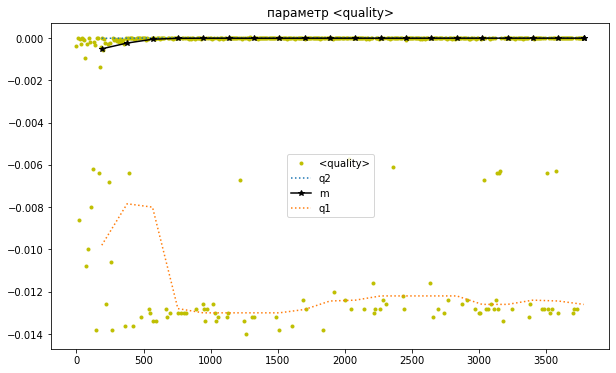

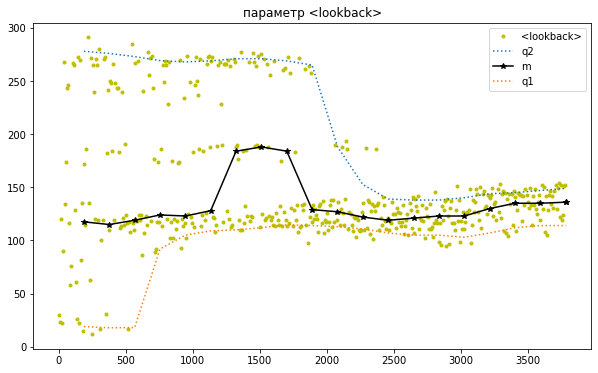

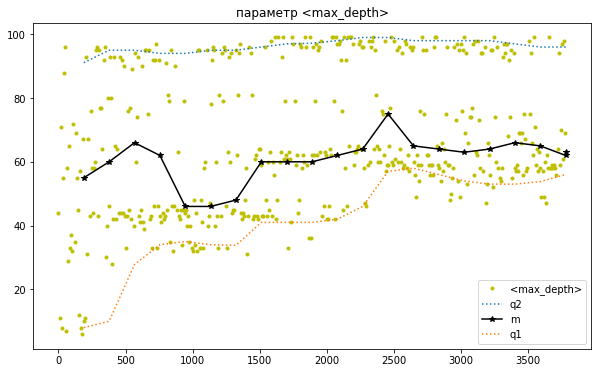

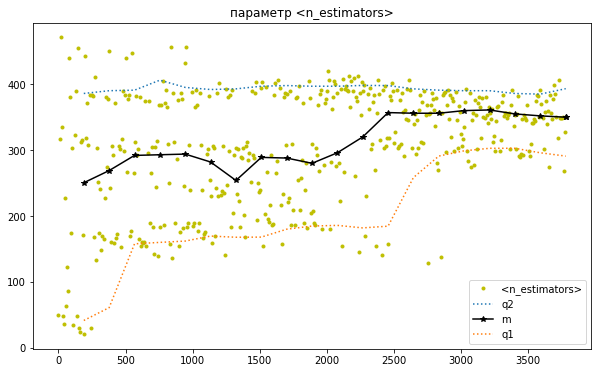

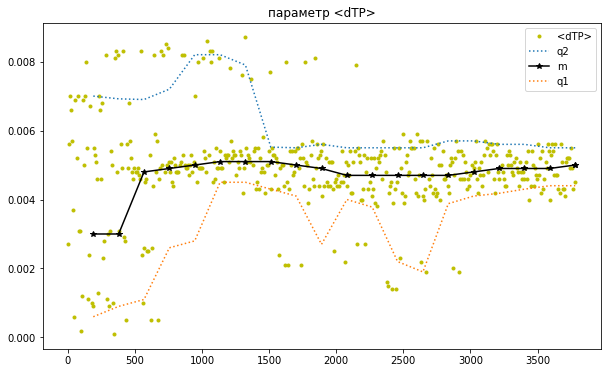

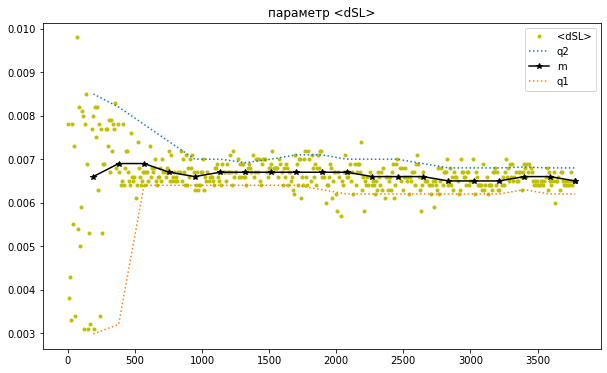

In [22]:
modelGA.plot_hist_new(('quality','lookback','max_depth','n_estimators','dTP','dSL'))

In [23]:
for n,h in enumerate(modelGA._hist):
    if h['new']['quality'] > 0:
        print(n,h['new'])


92 {'quality': 1.0061919504643962e-06, 'lookback': 27, 'max_depth': 12, 'n_estimators': 320, 'dTP': 0.0013, 'dSL': 0.004}
96 {'quality': 1.5698587127158556e-07, 'lookback': 76, 'max_depth': 37, 'n_estimators': 174, 'dTP': 0.0002, 'dSL': 0.0059}
110 {'quality': 5.685618729096989e-06, 'lookback': 271, 'max_depth': 73, 'n_estimators': 31, 'dTP': 0.0068, 'dSL': 0.0053}
143 {'quality': 5.409582689335401e-07, 'lookback': 25, 'max_depth': 9, 'n_estimators': 157, 'dTP': 0.0069, 'dSL': 0.0034}
146 {'quality': 2.5541795665634673e-06, 'lookback': 31, 'max_depth': 26, 'n_estimators': 315, 'dTP': 0.0011, 'dSL': 0.0057}
166 {'quality': 9.79899497487437e-06, 'lookback': 276, 'max_depth': 24, 'n_estimators': 302, 'dTP': 0.0056, 'dSL': 0.0073}
225 {'quality': 2.6273885350318476e-06, 'lookback': 119, 'max_depth': 92, 'n_estimators': 383, 'dTP': 0.008, 'dSL': 0.0069}
260 {'quality': 5.695142378559464e-06, 'lookback': 273, 'max_depth': 10, 'n_estimators': 353, 'dTP': 0.0068, 'dSL': 0.0053}
319 {'quality':

In [24]:
ansmbl.last

1085

## Параметры лучшей

In [25]:
best_par = modelGA.getBestParams()
best_par

{'dSL': 0.0065,
 'dTP': 0.0049,
 'lookback': 136,
 'max_depth': 70,
 'n_estimators': 348}

# Результаты ансамбля

In [26]:
# %%time
b_,s_,dTP_,dSL_,dTP_std,dSL_std,res=ansmbl.predict()
print('dTP_',dTP_,'dTP_std',dTP_std)
print('dSL_',dSL_,'dSL_std',dSL_std)
print('res',res,'%/year',((res+1)**252-1)*100)

dTP_ 0.004975 dTP_std 0.0003945567132872029
dSL_ 0.006492 dSL_std 0.00018093092604637827
res 0.0010331626370083818 %/year 29.721879148712517


In [27]:
df_=pd.DataFrame(index=data.index)
df_['BUY'] = b_
df_['BUY_open'] = data['<CLOSE>']
df_['BUY_tp'] = np.round(data['<CLOSE>']*(1+dTP_),2)
df_['BUY_sl'] = np.round(data['<CLOSE>']*(1-dSL_),2)
df_['SELL'] = s_
df_['SELL_open'] = data['<CLOSE>']
df_['SELL_tp'] = np.round(data['<CLOSE>']*(1-dTP_),2)
df_['SELL_sl'] = np.round(data['<CLOSE>']*(1+dSL_),2)
df_

,BUY,BUY_open,BUY_tp,BUY_sl,SELL,SELL_open,SELL_tp,SELL_sl
<DATE>,,,,,,,,
2008-01-09,NaN,101.85,102.36,101.19,NaN,101.85,101.34,102.51
2008-01-10,NaN,103.53,104.05,102.86,NaN,103.53,103.01,104.20
2008-01-11,NaN,104.70,105.22,104.02,NaN,104.70,104.18,105.38
2008-01-14,NaN,105.00,105.52,104.32,NaN,105.00,104.48,105.68
2008-01-15,NaN,105.71,106.24,105.02,NaN,105.71,105.18,106.40
...,...,...,...,...,...,...,...,...
2020-12-28,0.00,274.70,276.07,272.92,0.25,274.70,273.33,276.48
2020-12-29,0.00,272.00,273.35,270.23,0.00,272.00,270.65,273.77
2020-12-30,0.83,271.65,273.00,269.89,0.00,271.65,270.30,273.41
